In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import os

from matplotlib import pyplot as plt

In [2]:
event_id = 0 
hits = pd.read_csv('event00000100%d-hits.csv' % event_id )
particles = pd.read_csv('event00000100%d-particles.csv' % event_id)
truth = pd.read_csv('event00000100%d-truth.csv' % event_id)
cells = pd.read_csv('event00000100%d-cells.csv' % event_id)
detectors = pd.read_csv('detectors.csv')

In [3]:
def func_cleaning_data(cells , hits, particles , truth):
    #Finding all hit_id that is noice, to use in other files for removing nocie in them.
    def noice(truth):
        truth_hit_id_noice = [truth.hit_id[i] for i in range(len(truth)) if truth.particle_id[i] == 0]
        return truth_hit_id_noice
    truth_hit_id_noice_list = noice(truth)
    #Removing all the noice in the truth file:
    truth_zero_noice = truth.drop(truth.index[truth['particle_id'] == 0]).reset_index()
    #Removing all the data where the nhits is >=3 :
    particles_zero_noice = particles.drop(particles.index[particles['nhits'] <= 3]).reset_index()
    #Sorting the particles
    particles_zero_noice_sorted_unique = particles_zero_noice.sort_values(by = "particle_id",ascending=True)
    #Making a function that can remove all row that has a value in a list
    def FRBV(file_name, column_name, list_of_values):
        return file_name[~file_name[column_name].isin(list_of_values)]
    #Removing all the noice in the cells file:
    cells_zero_noice = FRBV(cells , "hit_id" , truth_hit_id_noice_list).reset_index()
    #Removing all the noice in the hits file:
    hits_zero_noice = FRBV(hits , "hit_id" , truth_hit_id_noice_list).reset_index()
    #Making a function that can remove all the data, that has a nhits over 7.
    def nhit_over_7(data):
        data = [data.particle_id[i] for i in range(len(data)) if data.nhits[i] > 7]
        return data
    #Removing all the data where nhits is less then 7
    particle_id_with_nhits_over_7 = nhit_over_7(particles_zero_noice_sorted_unique)
    #Removing all the data where nhits is over then 7
    particle_id_with_nhits_lees_7 = FRBV(particles_zero_noice_sorted_unique , "particle_id" , particle_id_with_nhits_over_7).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing all the data where a particle_id has more then 7 nhits.
    truth_zero_noice_nhits_lees_7 = FRBV(truth_zero_noice , "particle_id" , particle_id_with_nhits_over_7).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Making a function that can make a list of the hit_ids that has a weight of 0.
    def weight_equle_0(data):
        data = [data.hit_id[i] for i in range(len(data)) if data.weight[i] == 0]
        return data
    #Using the weight_equle_0 function to make a list of hit_id´s that has a weight equle 0
    truth_weight_0_list = weight_equle_0(truth_zero_noice_nhits_lees_7)
    #Using the list of hit_id´s that has a weight equle 0, to remove the rows in truth that has that hit_id.
    truth_zero_noice_nhits_lees_7_weight_0 = FRBV(truth_zero_noice_nhits_lees_7,"hit_id",truth_weight_0_list).reset_index().drop("index",axis = 1)
    
    #Removing the data where the particle_id has less then 7 nhits.
    truth_zero_noice_nhits_over_7 = FRBV(truth_zero_noice , "particle_id" ,truth_zero_noice_nhits_lees_7.particle_id).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing the data where the hit_id has less the 7 nhits.
    hits_zero_noice_nhits_lees_7 = FRBV(hits_zero_noice, "hit_id",truth_zero_noice_nhits_over_7["hit_id"]).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Making a list of all the particle_ids that has over 3 nhits
    particles_id_over_3 = [particles.particle_id[i] for i in range(len(particles)) if particles.nhits[i] > 3]
    #Removing all the data in truth that has less the 3 nhits. Used for later in cells and hits.  
    truth_zero_noice_over_3 = FRBV(truth_zero_noice,"particle_id",particles_id_over_3).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing all the data in hits that has over the 3 nhits.
    hits_zero_noice_nhits_lees_7_over_3_with_weight_0 = FRBV(hits_zero_noice_nhits_lees_7,"hit_id",truth_zero_noice_over_3.hit_id).reset_index().drop("index",axis = 1)
    #Making a list of hit_id that is not in truth but is in hits
    hit_id_in_hits_but_not_in_truth = FRBV(hits_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",truth_zero_noice_nhits_lees_7_weight_0.hit_id).reset_index().drop("index",axis = 1)
    #Using that hits not in truth, and then removing them from hits. 
    hits_zero_noice_nhits_lees_7_over_3_without_weight_0 = FRBV(hits_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",hit_id_in_hits_but_not_in_truth.hit_id).reset_index().drop("index",axis = 1)

    #Removing the data where the hit_id has less the 7 nhits.
    cells_zero_noice_nhits_lees_7 = FRBV(cells_zero_noice, "hit_id",truth_zero_noice_nhits_over_7["hit_id"]).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing all the data in cells that has over the 3 nhits.
    cells_zero_noice_nhits_lees_7_over_3_with_weight_0 = FRBV(cells_zero_noice_nhits_lees_7,"hit_id",truth_zero_noice_over_3.hit_id).reset_index().drop("index",axis = 1)
    #Making a list of hit_id that is not in truth but is in cells
    hit_id_in_cells_but_not_in_truth = FRBV(cells_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",truth_zero_noice_nhits_lees_7_weight_0.hit_id).reset_index().drop("index",axis = 1)
    #Using that cells hit_id not in truth, and then removing them from cells.
    cells_zero_noice_nhits_lees_7_over_3_without_weight_0 = FRBV(cells_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",hit_id_in_cells_but_not_in_truth.hit_id).reset_index().drop("index",axis = 1)
    
    return cells_zero_noice_nhits_lees_7_over_3_without_weight_0 , hits_zero_noice_nhits_lees_7_over_3_without_weight_0 , particle_id_with_nhits_lees_7 , truth_zero_noice_nhits_lees_7_weight_0

In [4]:
cells, hits, particles, truth = func_cleaning_data(cells , hits, particles , truth)

In [5]:
def cyl(x,y,z):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    z = z
    return r , phi , z

r , phi , z = cyl(hits.x, hits.y, hits.z)

hits['r'] = r
hits['phi'] = phi
hits['barcode'] = list(truth.particle_id)
truth

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,206,734116219916910592,-118.5700,-122.5160,-1502.0,-0.639702,-0.707372,-8.302040,0.000015
1,498,409840897669201920,72.5396,-94.1783,-1498.0,0.371663,-0.586782,-8.871780,0.000012
2,532,409840897669201920,72.7076,-94.4431,-1502.0,0.372535,-0.587447,-8.871220,0.000018
3,552,328769301148336128,44.3218,-28.1913,-1497.5,0.276163,-0.276955,-9.740100,0.000009
4,579,328769301148336128,44.4639,-28.3332,-1502.5,0.276819,-0.275671,-9.739620,0.000017
...,...,...,...,...,...,...,...,...,...
7260,120791,657537021765488641,247.2270,921.2370,2952.5,0.101673,0.127344,0.232226,0.000014
7261,120808,797151290273566721,85.8147,842.1130,2944.5,-0.039985,0.097445,0.123474,0.000020
7262,120843,968287938674692097,-336.7730,789.5170,2944.5,-0.093549,0.044940,0.143234,0.000020
7263,120854,144116356323741697,-478.9720,815.7910,2952.5,-0.312255,0.209192,0.310271,0.000020


In [6]:
barcode = np.unique(hits.barcode)
(hits.barcode[0])

734116219916910592

In [7]:
import statistics as st
r7 = max(r)
r1 = []
r2 = []
r3 = []
r4 = []
r5 = []
r6 = []
for i in range(len(r)):
    if r[i] >150 and r[i]<200:
        r1.append(r[i])
    if r[i]>200 and r[i] <350:
        r2.append(r[i])
    if r[i] > 270 and r[i] < 400:
        r3.append(r[i])
    if r[i] > 400 and r[i] < 600:
        r4.append(r[i])
    if r[i] > 600 and r[i] < 800:
        r5.append(r[i])
    if r[i] > 800 and r[i] < 1000:
        r6.append(r[i])
r1 = st.mode(r1)
r2 = st.mode(r2)
r3 = st.mode(r3)
r4 = st.mode(r4)
r5 = st.mode(r5)
r6 = st.mode(r6)
print(r7,r6,r5,r4,r3,r2,r1)

radii = [r1,r2,r3,r4,r5,r6,r7]

r1hitsx = []
r1hitsy = []
r1hitsz = []
for i in range(len(hits.x)):
    if (hits.x[i]**2 + hits.y[i]**2)**(1/2) >= radii[0] and abs(hits.z[i]) < 1000:
        r1hitsx.append((hits.x[i]))
        r1hitsy.append((hits.y[i]))
        r1hitsz.append((hits.z[i]))

1025.273945482377 823.2273047099445 658.341137157629 502.4718793813242 359.86612197454764 260.90290702289997 170.48622665775673


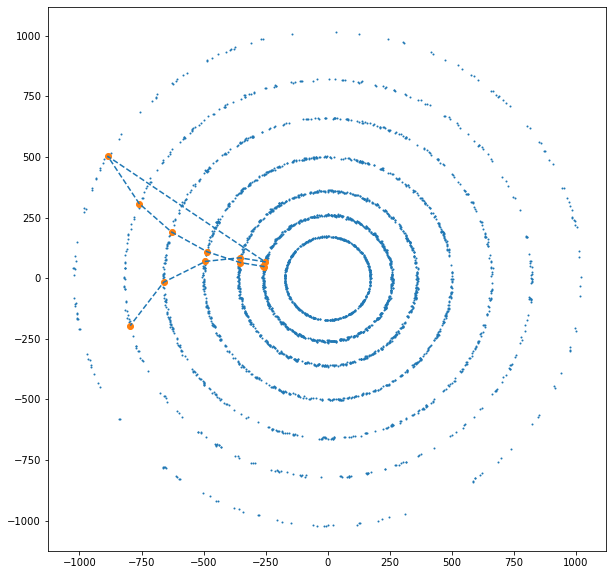

In [8]:
hix = []
hiy = []

for i in range(1,3):
    for k in range(len(hits.x)):
        if hits.barcode[k] == barcode[i]:
            hi = (hits.x[k])
            hy = (hits.y[k])
            
            hiy.append(hy)
            hix.append(hi)

plt.figure(figsize=(10,10))
plt.scatter(r1hitsx,r1hitsy, s= 1)
plt.plot(hix, hiy, '--' )
plt.scatter(hix, hiy)


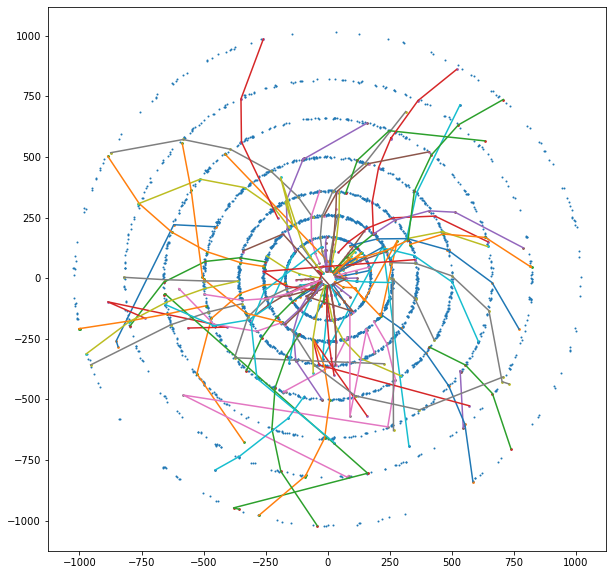

In [29]:
asd = []
for i in range(len(barcode)):
    asd.append(hits.loc[hits['barcode'] == barcode[i]])

asd = np.array(asd,dtype=object)
#print(asd[1].barcode,asd[1].x,asd[1].y,asd[1].z)

plt.figure(figsize=(10,10))
plt.scatter(r1hitsx,r1hitsy, s= 1)
for i in range(0,100):
    plt.scatter(asd[i].x, asd[i].y, s = 3)
    plt.plot(asd[i].x, asd[i].y)
  
